In [50]:
import keras
import tensorflow as tf
print('TensorFlow version:', tf.__version__)
print('Keras version:', keras.__version__)

Using TensorFlow backend.


TensorFlow version: 1.8.0
Keras version: 2.2.0


In [51]:
import os
from os.path import join
import json
import random
import itertools
import re
import datetime
# import cairocffi as cairo/
import editdistance
import numpy as np
from scipy import ndimage
import pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model, load_model
from keras.layers.recurrent import GRU
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.preprocessing import image
import keras.callbacks
import cv2

In [52]:
sess = tf.Session()
K.set_session(sess)

In [90]:
from collections import Counter
def get_counter(dirpath, tag):
    dirname = os.path.basename(dirpath)
    ann_dirpath = join(dirpath, 'ann').replace("\\","/")
    letters = ''
    lens = []
    for filename in os.listdir(ann_dirpath):#['C067TK53.json', 'O602HX64.json', 'A607TY24.json',...]
        json_filepath = join(ann_dirpath, filename).replace("\\","/")
        ann = json.load(open(json_filepath, 'r'))# json_filepath замын дагуу бүх json-уудыг сонгон авч уншиж байна.
        tags = ann['tags']
        if tag in tags:
            description = ann['description']
            lens.append(len(description))
            letters += description
    print('Max plate length in "%s":' % dirname, max(Counter(lens).keys()))
    return Counter(letters)# тэмдэгтүүдийг тоолоод dictionary-д хийж байна. {0:330} 0 цифер 330 удаа орсон
c_train = get_counter('./data/anpr_ocr__train', 'train')# train
letters_train = set(c_train.keys())# tarain дата-нд орсон бүх тэмдэгтүүдийг авч байна.
letters = sorted(list(letters_train))
print('Letters:', ' '.join(letters))

Max plate length in "anpr_ocr__train": 8
Letters: 0 1 6 A B C


In [108]:
def is_valid_str(s):
    for ch in s:
        if not ch in letters:
            return False
    return True

class TextImageGenerator:
    
    def __init__(self, 
                 dirpath,
                 tag,
                 img_w, img_h, 
                 batch_size, 
                 downsample_factor,
                 max_text_len=8):
        
        self.img_h = img_h
        self.img_w = img_w
        self.batch_size = batch_size
        self.max_text_len = max_text_len
        self.downsample_factor = downsample_factor
        
        img_dirpath = join(dirpath, 'img').replace("\\","/")
        print(img_dirpath)
        ann_dirpath = join(dirpath, 'ann').replace("\\","/")
        self.samples = []
        for filename in os.listdir(img_dirpath):
            name, ext = os.path.splitext(filename)# name = C067TK53, extention=  .json
            if ext in ['.png', '.jpg']:
                img_filepath = join(img_dirpath, filename).replace("\\","/")
                json_filepath = join(ann_dirpath, name + '.json').replace("\\","/")
                ann = json.load(open(json_filepath, 'r'))
                description = ann['description']
                tags = ann['tags']
                if tag not in tags:
                    continue
                if is_valid_str(description):# description-д байгаа техт letters-д байна уу гэж шалгаж байна.
                    self.samples.append([img_filepath, description])
        
        self.n = len(self.samples)# урт нь 557 байна.
        self.indexes = list(range(self.n))
        self.cur_index = 0
        
    def build_data(self):
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))# 557 ширхэг imgs (img_h X img_w)
        self.texts = []
        #[['../data/anpr_ocr__train/img/B500MK72.png', 'B500MK72'],...]
        for i, (img_filepath, text) in enumerate(self.samples):
            img = cv2.imread(img_filepath)# Зургийг уншиж байна.
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)#Хар цагаан болгож байна.
            img = cv2.resize(img, (self.img_w, self.img_h))# хэсжээг нь (34, 152, 3) to (64, 128) болгож байна
            img = img.astype(np.float32) # Утгуудыг нь float32 төрөлтөй болгож байна.
            img /= 255 # index дэхь бүх утгуудыг 255-д хувааж байна.
            plt.imshow(img, cmap='gray')
            plt.show()
#             break
            self.imgs[i, :, :] = img
            self.texts.append(text)

In [111]:
def train(img_w, load=False):
    # Input Parameters
    img_h = 64

    # Network parameters
    conv_filters = 16
    kernel_size = (3, 3)
    pool_size = 2
    time_dense_size = 32
    rnn_size = 512

    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)
        
    batch_size = 32
    downsample_factor = pool_size ** 2
    tiger_train = TextImageGenerator('./data/anpr_ocr__train', 'train', img_w, img_h, batch_size, downsample_factor)
    tiger_train.build_data()
    tiger_val = TextImageGenerator('./data/anpr_ocr__train', 'val', img_w, img_h, batch_size, downsample_factor)
    tiger_val.build_data()

    act = 'relu'
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')
    print(input_data)
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv1')(input_data)
    print(inner)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv2')(inner)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)

    conv_to_rnn_dims = (img_w // (pool_size ** 2), (img_h // (pool_size ** 2)) * conv_filters)
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

    # cuts down input size going into RNN:
    inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

    # Two layers of bidirecitonal GRUs
    # GRU seems to work as well, if not better than LSTM:
    gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
    gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
    gru1_merged = add([gru_1, gru_1b])
    gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

    # transforms RNN output to character activations:
    inner = Dense(tiger_train.get_output_size(), kernel_initializer='he_normal',
                  name='dense2')(concatenate([gru_2, gru_2b]))
    y_pred = Activation('softmax', name='softmax')(inner)
    Model(inputs=input_data, outputs=y_pred).summary()

    labels = Input(name='the_labels', shape=[tiger_train.max_text_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

    # clipnorm seems to speeds up convergence
    sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)

    if load:
        model = load_model('./tmp_model.h5', compile=False)
    else:
        model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)

    # the loss calc occurs elsewhere, so use a dummy lambda func for the loss
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
    
    if not load:
        # captures output of softmax so we can decode the output during visualization
        test_func = K.function([input_data], [y_pred])

        model.fit_generator(generator=tiger_train.next_batch(), 
                            steps_per_epoch=tiger_train.n,
                            epochs=1, 
                            validation_data=tiger_val.next_batch(), 
                            validation_steps=tiger_val.n)

    return model

./data/anpr_ocr__train/img


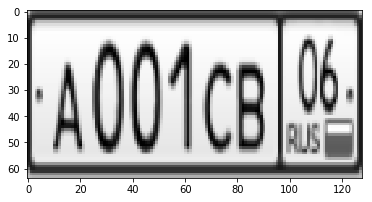

./data/anpr_ocr__train/img
Tensor("the_input_3:0", shape=(?, 128, 64, 1), dtype=float32)
Tensor("conv1_3/Relu:0", shape=(?, 128, 64, 16), dtype=float32)


AttributeError: 'TextImageGenerator' object has no attribute 'get_output_size'

In [112]:
model = train(128, load=False)